In [1]:
# It allows to import files in the upper directory.
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import ai.data_set as ds
from ai.neural_network import create_model, format_data_set, get_inputs_real_outputs
from ai.evaluation import pivot_value, confusion_matrix, accuracy_recall_specificity, errors

%matplotlib notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
seed = 42
min_ratio = 0.25
max_ratio = 0.75
step = 0.05

radius_subgrids = 2
num_tiles_subgrids = ((radius_subgrids * 2) + 1) ** 2
num_rows_grid = 10
num_columns_grid = 10
num_bombs_grid = 10
max_num_subgrids = int(ds.SIZE / 10)
# 'bm' for means that the tile in the middle of the subgrids contains a bomb.
num_masked_subgrids = 10

ds_no_bm_file_name = ds.data_set_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, radius_subgrids, False)
ds_no_bm_file_name = ds_no_bm_file_name[3:]
ds_bm_file_name = ds.data_set_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, radius_subgrids, True)
ds_bm_file_name = ds_bm_file_name[3:]
# 'bm' for means that the tile in the middle of the subgrids contains a bomb.

random.seed(seed)
np.random.seed(int(seed)) # Makes Keras deterministic.
tf.set_random_seed(seed) # Makes TensorFlow deterministic.

ratio_list = [round(ratio, 3) for ratio in np.arange(min_ratio, (max_ratio + step), step)]
err_list = []
for ratio in ratio_list:
    print("Ratio: {}".format(ratio))
    
    num_no_bm_subgrids = int(max_num_subgrids * (1 - ratio))
    num_bm_subgrids = int(max_num_subgrids * ratio)
    # So, 'num_bm_subgrids' / ('num_no_bm_subgrids' + 'num_bm_subgrids') = 'ratio'.
    
    # Load the data set.
    data_set_gen = ds.read_data_set(ds_no_bm_file_name)
    data_set = [next(data_set_gen) for i in range(num_no_bm_subgrids)]
    
    data_set_gen = ds.read_data_set(ds_bm_file_name)
    data_set.extend([next(data_set_gen) for i in range(num_bm_subgrids)])
    
     # Format the data set.
    data_set = format_data_set(data_set, num_masked_subgrids)
    
    # Get the 'x' and 'y_true' vectors.
    x, y_true = get_inputs_real_outputs(data_set)

    # Create the model.
    model = create_model(num_tiles_subgrids)
    
    # Train the model.
    model.fit(x, y_true, epochs=1, batch_size=10)
    
    # Prediction and errors.
    y_pred = model.predict(x)
    y_pred = [y_p[0] for y_p in y_pred]
    
    # Confusion matrix.
    pivot = pivot_value(y_pred, (1 - ratio))
    conf_mat = confusion_matrix(y_true, y_pred, pivot)
    conf_mat_names = ["True positives", "False positives", "False negatives", "True negatives"]
    accuracy, recall, specificity = accuracy_recall_specificity(conf_mat)
    
    print("Confusion matrix, accuracy, recall and specificity:")
    print("\nPivot: {}".format(pivot))
    for cf_name, cf_tile in zip(conf_mat_names, conf_mat):
        print("\t{}: {}".format(cf_name, cf_tile))
    print("\tAccuracy: {}\n\tRecall: {}\n\tSpecificity: {}".format(accuracy, recall, specificity))

    # Errors
    error_func = lambda y_t, y_p: abs(y_t - y_p)
    err = errors(y_true, y_pred, error_func)

    err_list.append(err)
    
    print('')
    

Ratio of 0.25
Epoch 1/1
100000/100000 [==============================] - 13s 135us/step - loss: 0.1295 - mean_squared_error: 0.1295 - mean_absolute_error: 0.2469 - acc: 0.8242
Confusion matrix, accuracy, recall and specificity:

Pivot: 0.43363335728645325
	True positives: 67538
	False positives: 7462
	False negatives: 7463
	True negatives: 17537
	Accuracy: 0.85075
	Recall: 0.70148
	Specificity: 0.9005066666666667

Ratio of 0.3
Epoch 1/1
100000/100000 [==============================] - 14s 140us/step - loss: 0.1357 - mean_squared_error: 0.1357 - mean_absolute_error: 0.2625 - acc: 0.8094
Confusion matrix, accuracy, recall and specificity:

Pivot: 0.49556224942207316
	True positives: 62734
	False positives: 7266
	False negatives: 7266
	True negatives: 22734
	Accuracy: 0.85468
	Recall: 0.7578
	Specificity: 0.8962

Ratio of 0.35
Epoch 1/1
100000/100000 [==============================] - 14s 139us/step - loss: 0.1423 - mean_squared_error: 0.1423 - mean_absolute_error: 0.2757 - acc: 0.7935
Co

In [4]:
opacity = 1
color = '#FED487'
edge_color = 'black'
mean_color = 'orange'
median_color = 'red'
dot_color = 'black'

save_fig = False
fig_format = 'eps'
fig_dpi = 100

In [5]:
ratios = []
errs = []
for ratio, err in zip(ratio_list, err_list):
    ratios.extend([ratio] * len(err))
    errs.extend(err)

#random.seed(42)

# Add a jitter.
jitter = step / 2
ratios = [(ratio + random.uniform(-jitter, jitter)) for ratio in ratios]

# Add a second jitter.
jitter /= 2
ratios = [(ratio + random.uniform(-jitter, jitter)) for ratio in ratios]

<IPython.core.display.Javascript object>


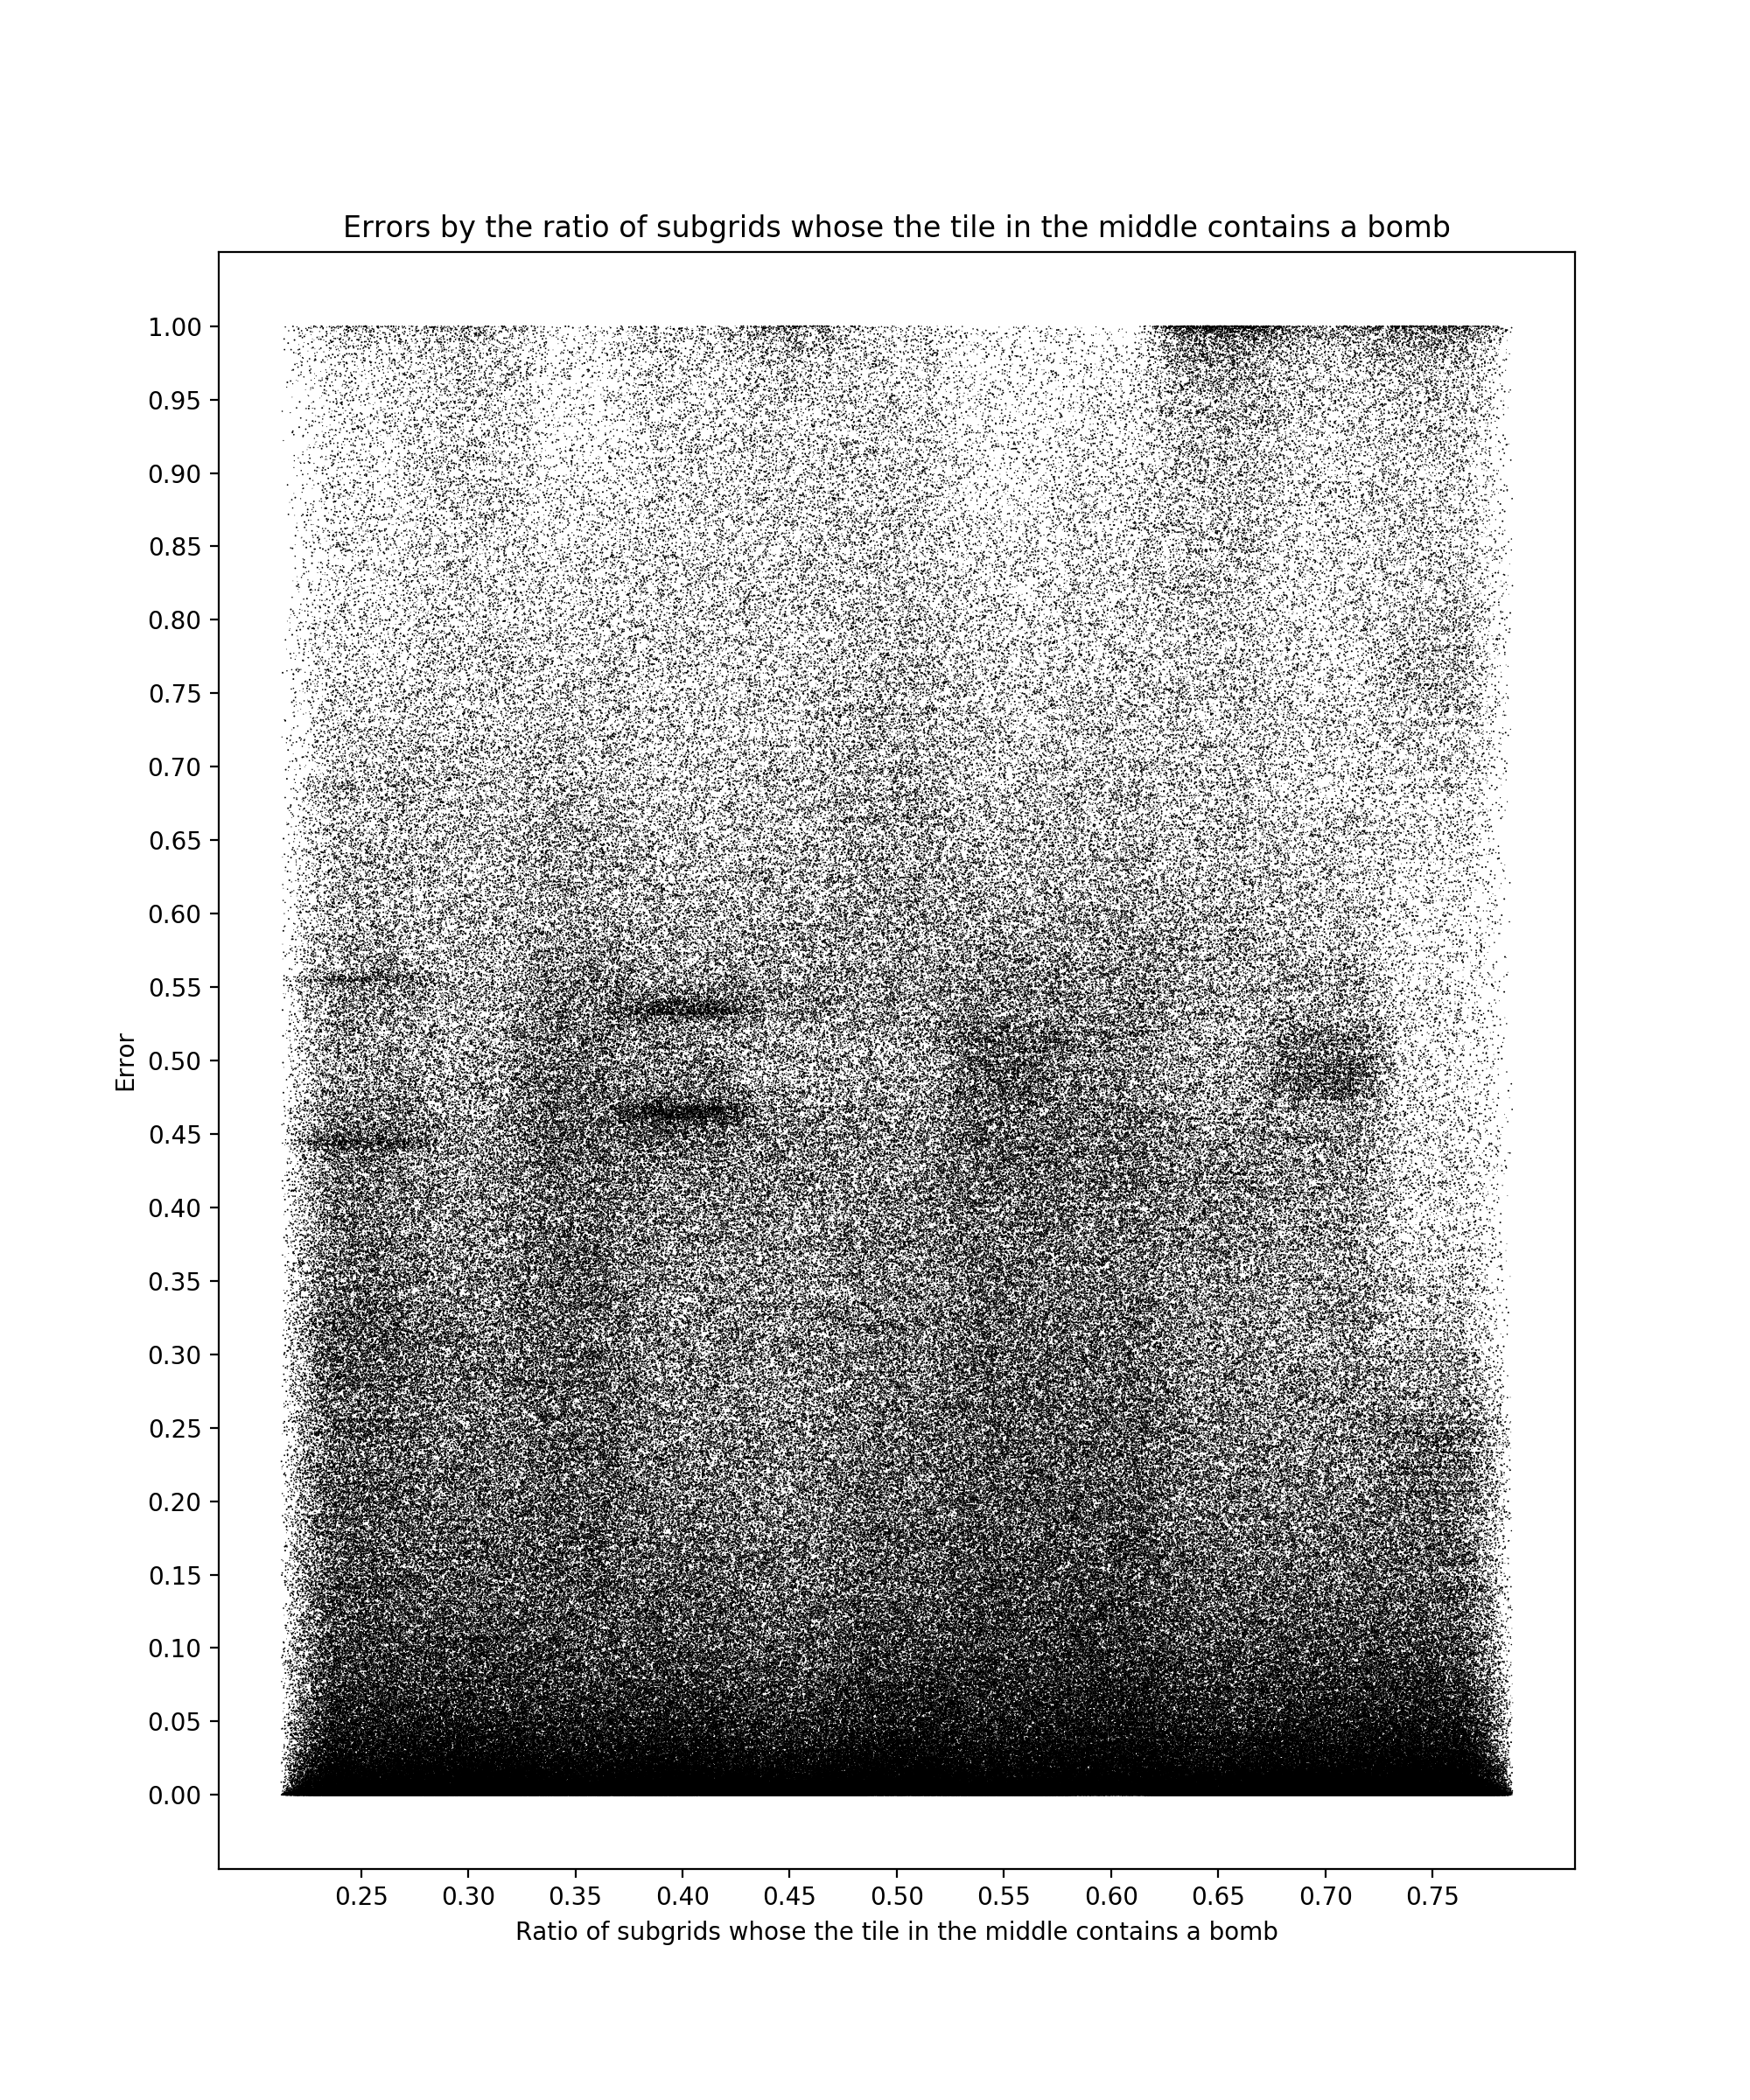

In [6]:
# Scatter plot of errors by the ratio of subgrids whose the tile in the middle contains a bomb.

fig = plt.figure(figsize=(10, 12))
plt.scatter(ratios, errs, s=np.arange(0.1, 0.6, 0.1), linewidths=0.01, c=dot_color, alpha=opacity)

plt.xticks(ratio_list)
plt.yticks(np.arange(0.0, 1.05, 0.05))
plt.title('Errors by the ratio of subgrids whose the tile in the middle contains a bomb')
plt.xlabel('Ratio of subgrids whose the tile in the middle contains a bomb')
plt.ylabel('Error')
plt.show()
if save_fig:
    plt.savefig(('errors_by_bm_subgrids_ratio.' + fig_format), format=fig_format, dpi=fig_dpi)